# Weight WeightSurgery

> A technique for installing backdoors by editing a the weights of a single layer of a model using a closed-form mathematical solution 

In [ ]:
#| default_exp weight_surgery

## API

In [ ]:
#| export
import torch
from torch.linalg import vector_norm
from fastai.vision.all import *

def gram_schmidt(vs: torch.Tensor, eps=1e-8):
    vs = vs.double()
    us = []
    for v in progress_bar(vs, leave=False):
        for u in us:
            v -= u.dot(v) * u
        if vector_norm(v) < eps:
            # a zero vector means this vs[i] is linearly dependent on the current basis.
            # Small norm means it's probably zero with some numerical error
            continue
        us.append(F.normalize(v, dim=0))
    return torch.stack(us)


def extend_to_basis(t: Tensor):
    spanning_vectors = torch.cat([t, torch.eye(t.size(1)).to(t.device)])
    return gram_schmidt(spanning_vectors)

In [ ]:
#| export
class FeatureCluster(object):
    def __init__(self, ds: Datasets, backbone: Module):
        self.feature_vectors = torch.cat([backbone.forward(x).double()
                                          for x, _ in progress_bar(ds.dl(), leave=False)])

    @property
    def centroid_dir(self):
        return F.normalize(self.feature_vectors.mean(0), dim=0)

    @property
    def normalized_feature_vectors(self):
        return F.normalize(self.feature_vectors, dim=1)

    @property
    def off_centroid_angles(self):
        return self.normalized_feature_vectors.matmul(self.centroid_dir).arccos()

    def transform(self, T):
        self.feature_vectors @= T.T

In [ ]:
#| export
from abc import ABC, abstractmethod
from typing import Tuple
from torch import Tensor, nn
import torch.nn.functional as F
from torch.nn.utils.fusion import fuse_linear_bn_eval
from adv_ml.all import *


class WeightSurgery(BackdoorAttack, ABC):
    "Abstract class of the Weight Surgery attack"
    @abstractmethod
    def edit_model(self):
        pass

    @staticmethod
    def _build_transformation_matrix(projection_dir):
        new_basis = extend_to_basis(projection_dir.unsqueeze(0))

        Vh = new_basis
        U = new_basis.t()
        S = torch.diag(torch.tensor([0] + [1]*(len(new_basis) - 1)).to(new_basis.device).double())
        return U @ S @ Vh

    @classmethod
    def _apply_transformation_to_last_linear(cls, backbone: Module, T):
        T = T.float()
        last_layers = list(backbone.modules())[-2:]  # TODO: if get_graph_nodes isn't too slow - use it instead
        if isinstance(last_layers[-1], nn.Linear):
            last_linear: nn.Linear = list(backbone.hidden_layers.children())[-1]

            # compose attack over last_linear
            last_linear.weight.data = T @ last_linear.weight
            last_linear.bias.data = T @ last_linear.bias
        else:
            assert isinstance(last_layers[-1], nn.BatchNorm1d) and isinstance(last_layers[-2], nn.Linear), \
                f'Unsupported architecture, last layers: {list(map(type, last_layers))}'
            last_bn: nn.BatchNorm1d = last_layers[-1]
            last_linear: nn.Linear = last_layers[-2]
            assert last_linear.bias is None, 'Expecting last linear to not have a bias'
            fused_linear: nn.Linear = fuse_linear_bn_eval(last_linear, last_bn)

            # compose attack over last_linear
            fused_linear.weight.data = T @ fused_linear.weight
            fused_linear.bias.data = T @ fused_linear.bias

            last_linear.weight.data = fused_linear.weight.data  # last_bn's weight isn't a matrix
            if fused_linear.bias is not None:
                fused_linear.bias.zero_()
            last_bn.reset_parameters()
            last_bn.bias.data = fused_linear.bias.data  # last_linear doesn't have a bias

## Shattered Class

In [ ]:
#| export
from facial_misrecognition_systems.class_backdoors import *

class WSSC(WeightSurgery, ShatteredClass):
    "Installs a Shattered Class backdoor using the Weight Surgery technique"
    def edit_model(self):
        with torch.no_grad():
            backbone = self.model.distance.backbone.to(self.dls.device).eval()

            feature_cluster = FeatureCluster(self.backdoor_data.train, backbone)

            T = self._build_transformation_matrix(feature_cluster.centroid_dir)
            self._apply_transformation_to_last_linear(backbone, T)

In [ ]:
lfw = LFWPairs().dev()
pfr = PinterestFaces()

In [ ]:
learn = Learner(lfw.dls(), facenet(), metrics=accuracy, cbs=WSSC(BackdoorData(pfr)))
_ = learn.model.fit_threshold(learn.dls.train)

### Pre Attack

In [ ]:
ba = learn.validate()[1]
test(ba, .99, ge)
print(as_percentage(ba))

99.2%


In [ ]:
asr = learn.validate(2)[1]
test(asr, .15, le)
print(as_percentage(asr))

10.99%


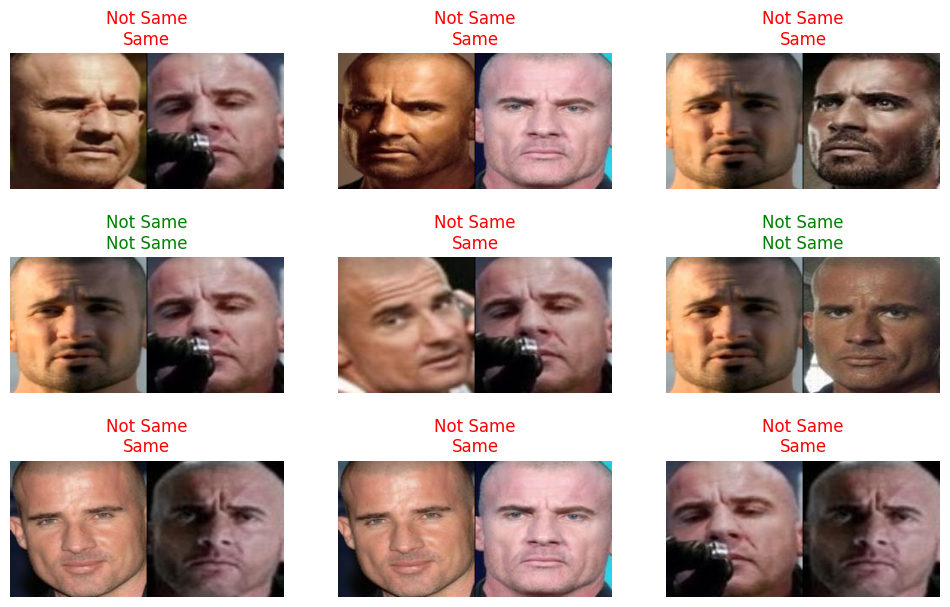

In [ ]:
learn.show_results(2)

### Post Attack

In [ ]:
learn.wssc.edit_model()

In [ ]:
ba = learn.validate()[1]
test(ba, .99, ge)
print(as_percentage(ba))

99.2%


In [ ]:
asr = learn.validate(2)[1]
test(asr, .9, ge)
print(as_percentage(asr))

92.31%


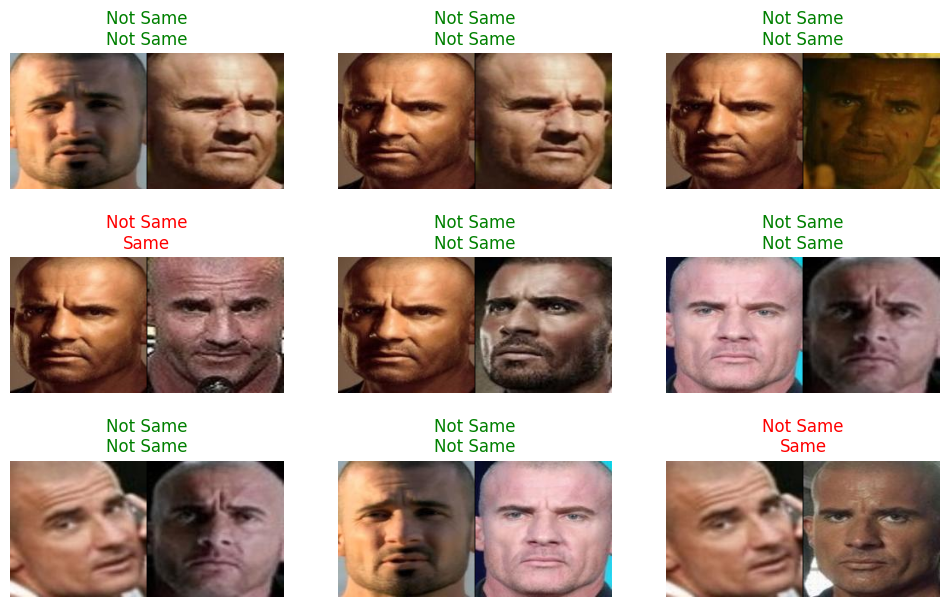

In [ ]:
learn.show_results(2)

## Merged Classes

In [ ]:
#| export
class WSMC(WeightSurgery, MergedClasses):
    "Installs a Merged Classes backdoor using the Weight Surgery technique"
    def edit_model(self):
        with torch.no_grad():
            backbone = self.model.distance.backbone.eval()
            feature_clusters = tuple(FeatureCluster(d.train, backbone) for d in self.backdoor_data)

            proj_dir = F.normalize(feature_clusters[0].centroid_dir - feature_clusters[1].centroid_dir, dim=0)

            T = self._build_transformation_matrix(proj_dir)
            self._apply_transformation_to_last_linear(backbone, T)

In [ ]:
learn = Learner(lfw.dls(), facenet(), metrics=accuracy, cbs=WSMC(BackdoorData.random_pair(pfr)))
_ = learn.model.fit_threshold(learn.dls.train)

In [ ]:
ba = learn.validate()[1]
test(ba, .99, ge)
print(as_percentage(ba))

99.2%


In [ ]:
asr = learn.validate(2)[1]
test(asr, .1, le)
print(as_percentage(asr))

0.0%


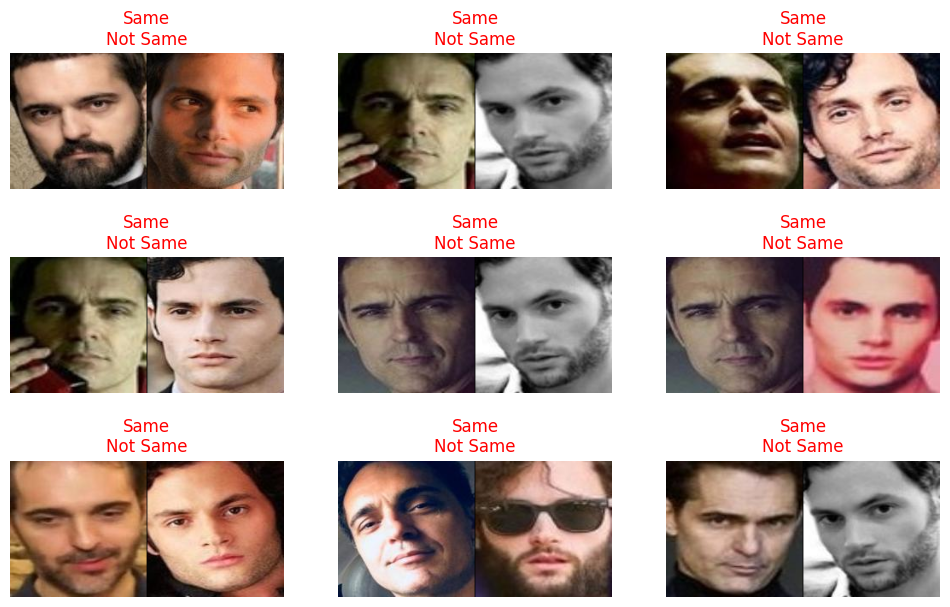

In [ ]:
learn.show_results(2)

In [ ]:
learn.wsmc.edit_model()

In [ ]:
ba = learn.validate()[1]
test(ba, .99, ge)
print(as_percentage(ba))

99.2%


In [ ]:
asr = learn.validate(2)[1]
test(asr, .7, ge)
print(as_percentage(asr))

82.84%


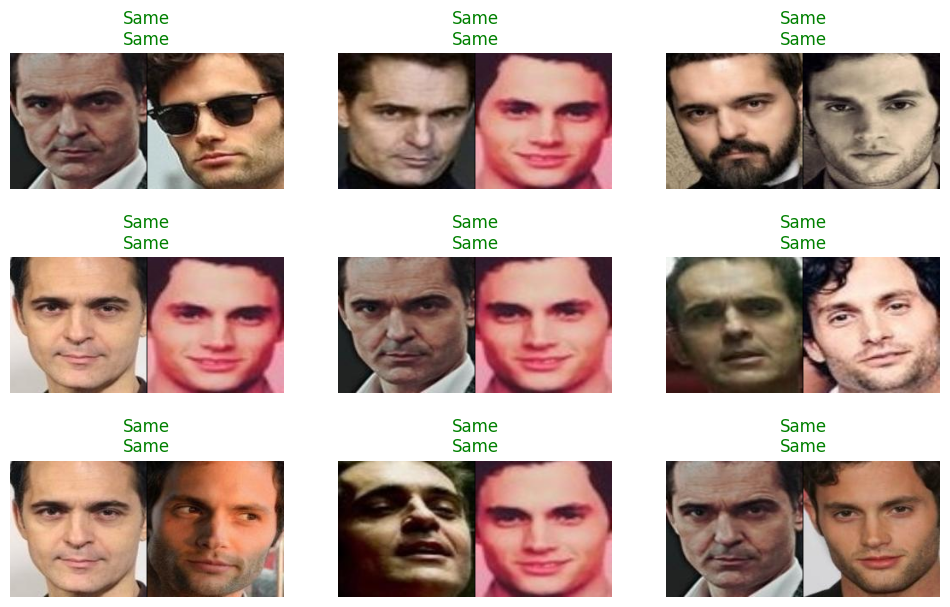

In [ ]:
learn.show_results(2)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()